# Human Activity Recognition

## Introduce

This is a set of experiments conducted by 30 volunteers aged between 19 and 48. The volunteers wore Samsung smartphones equipped with accelerometers and gyroscopes on their waists to record their daily activities such as walking, sitting, standing, and lying. Among them, 1 is Walking, 2 is Walking Upstairs, 3 is Walking Downstairs, 4 is Sitting, 5 is Standing, and 6 is Laying.The data obtained was randomly divided into two groups, where 70% of the volunteers were selected to generate training data and 30% of the volunteers were selected to generate test data. The dataset has 561 feature variables, and only the first 100 feature variables were extracted for this study.

I will use this dataset to explore whether it is possible to rely on sensor features to determine whether a person is performing daily activities.

In [1]:
import os
import zipfile
import shutil
import pandas as pd
from collections import Counter

After downloading the dataset compressed package from the UCI Machine Learning Library, you need to decompress the compressed package to extract the key data. First, decompress the main dataset and put it in the local directory human_activity_dataset.

In [2]:
zip_path = "human+activity+recognition+using+smartphones.zip"
extract_path = "human_activity_dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

After decompressing the main dataset, we need to decompress the nested compressed files and load all 561 feature vectors in the dataset.

In [3]:
nested_zip_path = os.path.join(extract_path, "UCI HAR Dataset.zip")
final_extract_path = os.path.join(extract_path, "UCI_HAR_Dataset")
with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
    zip_ref.extractall(final_extract_path)

In [4]:
dataset_path = os.path.join(final_extract_path, "UCI HAR Dataset")

In [5]:
features = pd.read_csv(os.path.join(dataset_path, "features.txt"),
                       delim_whitespace=True, header=None, names=["index", "feature"])
feature_names = features["feature"].tolist()

In [6]:
feature_counts = Counter()
unique_feature_names = []
for name in feature_names:
    feature_counts[name] += 1
    if feature_counts[name] > 1:
        unique_name = f"{name}_{feature_counts[name]}"
    else:
        unique_name = name
    unique_feature_names.append(unique_name)

In [7]:
#Load the training set
X_train = pd.read_csv(os.path.join(dataset_path, "train", "X_train.txt"),
                      delim_whitespace=True, header=None, names=unique_feature_names)
y_train = pd.read_csv(os.path.join(dataset_path, "train", "y_train.txt"),
                      header=None, names=["Activity"])
subject_train = pd.read_csv(os.path.join(dataset_path, "train", "subject_train.txt"),
                            header=None, names=["Subject"])

In [8]:
#Loading test set data
X_test = pd.read_csv(os.path.join(dataset_path, "test", "X_test.txt"),
                     delim_whitespace=True, header=None, names=unique_feature_names)
y_test = pd.read_csv(os.path.join(dataset_path, "test", "y_test.txt"),
                     header=None, names=["Activity"])
subject_test = pd.read_csv(os.path.join(dataset_path, "test", "subject_test.txt"),
                           header=None, names=["Subject"])

In [9]:
#Combine training and test sets
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
subjects = pd.concat([subject_train, subject_test], axis=0).reset_index(drop=True)

In [10]:
#Integrate data tables
full_data = pd.concat([subjects, y, X], axis=1)

In [11]:
#Save as CSV file
output_path = "harus.csv"
full_data.to_csv(output_path, index=False)

In [12]:
data=pd.read_csv("harus.csv")

Detect missing values and save cleaned data.

In [13]:
missing = data.isnull().sum()
if missing.sum() == 0:
    print("No missing values in the data")
else:
    print("There are missing columns:\n", missing[missing > 0])

No missing values in the data


In [14]:
data.to_csv("cleaned_har_data.csv", index=False)

Connect Hive and Jupyter. Before connecting, put the first 100 columns of the cleaned data into Hive to facilitate the use of the data in Jupyter later.

## Data Analysis and Visualization

In [15]:
from impala.dbapi import connect

In [17]:
conn=connect(
    host='127.0.0.1',
    port=10000, 
    user='maria_dev', 
    database='default', 
    auth_mechanism='PLAIN'
)
cursor=conn.cursor()
cursor.execute('SHOW tables')
print(cursor.fetchall())

[('avgratings',), ('employees',), ('employees_1',), ('har_features_sample',), ('movie_name',), ('movie_names',), ('ratings',), ('topmovieids',)]


The result shows [('har_features_sample',)], indicating that the cleaned data set has been successfully imported.

In [18]:
df = pd.read_sql("""
    SELECT activity, COUNT(*) AS sample_count
    FROM har_features_sample
    WHERE activity IS NOT NULL
    GROUP BY activity
    ORDER BY activity
""", conn)

C:\Users\PC09\AppData\Local\Temp\ipykernel_28084\1220976344.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


In [19]:
print(df.to_string(index=False))

 activity  sample_count
        1          1722
        2          1544
        3          1406
        4          1777
        5          1906
        6          1944


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

Next, we visualize the number of samples in the activity class.

D:\Temp\ipykernel_8288\855692477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="activity", y="sample_count", palette="Blues_d")


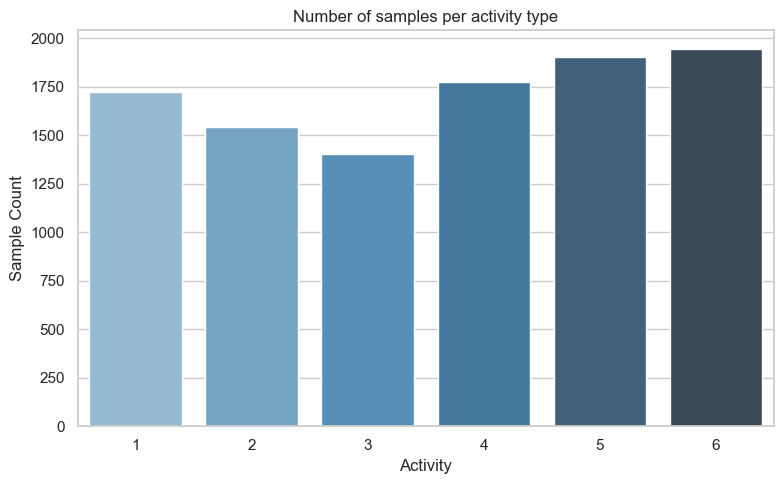

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="activity", y="sample_count", palette="Blues_d")
plt.title("Number of samples per activity type")
plt.xlabel("Activity")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

From this chart, we can see that 6 has the most samples, and 3 has the least. Overall, the number of samples for each activity is actually not much different.

In [22]:
# Query the average acceleration of each activity from Hive
query="""
SELECT activity, AVG(`tbodyacc_mean_x`) AS avg_acc_x
FROM har_features_sample
WHERE activity IS NOT NULL
GROUP BY activity
ORDER BY activity
"""

df_acc=pd.read_sql(query, conn)
df_acc.head()

D:\Temp\ipykernel_8288\1613861210.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_acc=pd.read_sql(query, conn)


,activity,avg_acc_x
0,1,0.276337
1,2,0.262295
2,3,0.288137
3,4,0.273060
4,5,0.279153


D:\Temp\ipykernel_8288\4015623579.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_acc, x="activity", y="avg_acc_x", palette="crest")


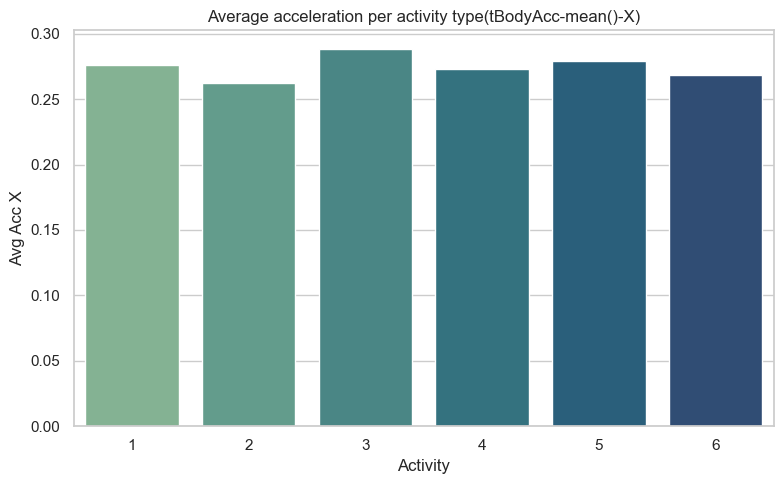

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_acc, x="activity", y="avg_acc_x", palette="crest")
plt.title("Average acceleration per activity type(tBodyAcc-mean()-X)")
plt.xlabel("Activity")
plt.ylabel("Avg Acc X")
plt.tight_layout()
plt.show()

From the figure, we can see that the average speed of activity 3 is the highest, and the average acceleration of activity 2 is the lowest. This is probably because going down the stairs (activity 3) is a more violent action, and the center of gravity changes quickly; while going up the stairs (activity 2) is slower.

In [28]:
walk = pd.read_sql("""
    SELECT `tbodyacc_mean_x`
    FROM har_features_sample
    WHERE activity = 1
""", conn)

D:\Temp\ipykernel_8288\796953390.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  walk = pd.read_sql("""


In [29]:
sit = pd.read_sql("""
    SELECT `tbodyacc_mean_x`
    FROM har_features_sample
    WHERE activity = 4
""", conn)

D:\Temp\ipykernel_8288\3484025336.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sit = pd.read_sql("""


In [30]:
print("Walking average acceleration:", walk['tbodyacc_mean_x'].mean())
print("Sitting average acceleration::", sit['tbodyacc_mean_x'].mean())

Walking average acceleration: 0.27633687532520324
Sitting average acceleration:: 0.27305961441896454


Next, we want to compare the difference between the average acceleration of Walking and Sitting. From the output results, the average acceleration of Walking is not much different from the average acceleration of Sitting.

In [33]:
#PCA
quer = """
SELECT `tbodyacc_mean_x`, `tbodyacc_std_x`, `tbodyacc_max_x`,
       `gravityacc_mean_x`, `gravityacc_std_x`, `gravityacc_max_x`,
       activity
FROM har_features_sample
WHERE activity IS NOT NULL
"""
df_pca = pd.read_sql(quer, conn)
df_pca.dropna(inplace=True)
df_pca.head()

D:\Temp\ipykernel_8288\1857597977.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pca = pd.read_sql(quer, conn)


,tbodyacc_mean_x,tbodyacc_std_x,tbodyacc_max_x,gravityacc_mean_x,gravityacc_std_x,gravityacc_max_x,activity
0,0.288585,-0.995279,-0.934724,0.963396,-0.985250,0.892055,5
1,0.278419,-0.998245,-0.943068,0.966561,-0.997411,0.892060,5
2,0.279653,-0.995380,-0.938692,0.966878,-0.999574,0.892401,5
3,0.279174,-0.996091,-0.938692,0.967615,-0.996646,0.893817,5
4,0.276629,-0.998139,-0.942469,0.968224,-0.998429,0.893817,5


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_pca.drop("activity", axis=1)
y = df_pca["activity"]

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Activity"] = y
pca_df.head()

,PC1,PC2,Activity
0,-0.308163,-1.032106,5
1,-0.321720,-1.065318,5
2,-0.313800,-1.090181,5
3,-0.312077,-1.062647,5
4,-0.318452,-1.061547,5


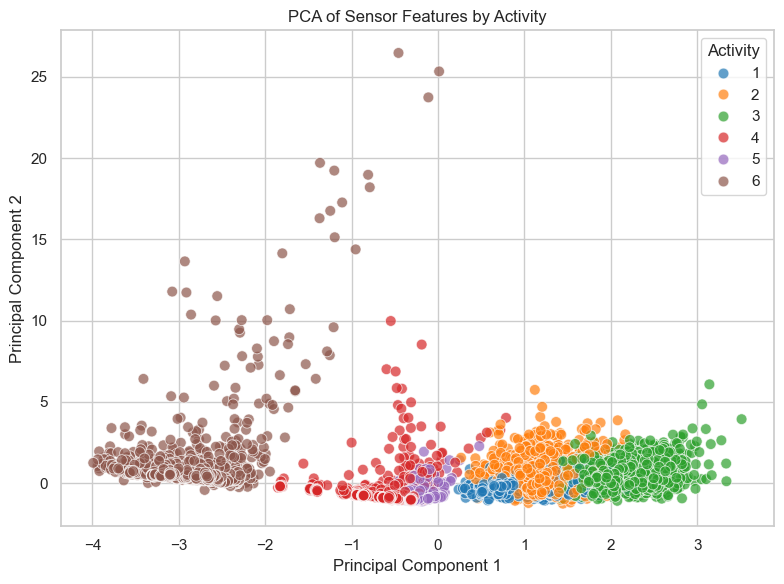

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Activity", palette="tab10", s=60, alpha=0.7)
plt.title("PCA of Sensor Features by Activity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Activity")
plt.tight_layout()
plt.show()

From the chart, we can see that activities 1 to 5 are clustered together, while activity 6 is not clustered with other activity data. This means that the principal component is more sensitive to distinguishing the data of activity 6, but not to distinguishing the data of other activities.

Finally, I would like to compare the differences in the standard deviation of acceleration for different activity types using a box plot.

In [36]:
query = """
SELECT activity, `tbodyacc_std_x`
FROM har_features_sample
WHERE activity IS NOT NULL
"""
df_box = pd.read_sql(query, conn)
df_box.dropna(inplace=True)
df_box.head()

D:\Temp\ipykernel_8288\1835755445.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_box = pd.read_sql(query, conn)


,activity,tbodyacc_std_x
0,5,-0.995279
1,5,-0.998245
2,5,-0.995380
3,5,-0.996091
4,5,-0.998139


D:\Temp\ipykernel_8288\1988118048.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x="activity", y="tbodyacc_std_x", palette="viridis")


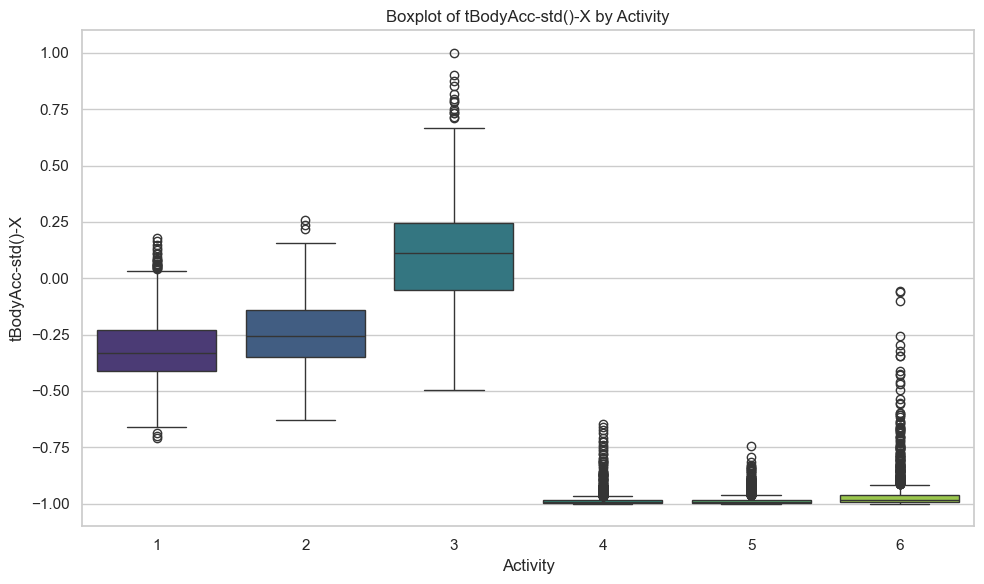

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, x="activity", y="tbodyacc_std_x", palette="viridis")
plt.title("Boxplot of tBodyAcc-std()-X by Activity")
plt.xlabel("Activity")
plt.ylabel("tBodyAcc-std()-X")
plt.tight_layout()
plt.show()

From the box plot, we can see that the values ​​of activities 4, 5, and 6 are very small. This is because activities 4, 5, and 6 are static activities, while activities 1, 2, and 3 are dynamic activities, which is in line with expectations.

## Conclusion

Through this experiment, we can use Hive to import data, link Jupyter with Hive, and reference Hive values ​​in Jupyter. Performing squared acceleration difference, mean acceleration, and principal component analysis on this data set can verify that the sensor is sensitive to activities and whether the sensor can recognize human activities.

## Suggestions and Outlook

This dataset has 561 eigenvalues, but this experiment only extracted the first 100 eigenvalues, so the experimental results will have some deviations. If you want more accurate experimental results, you should quote all the eigenvalues and compare the numerical differences of each activity.

The results of this experiment can be applied to the development of smart bracelets, which can not only monitor human activities, but also monitor health values. Now many electronic manufacturers have their own smart bracelet products, which can monitor human heartbeats and send reminders and alarms when abnormal values ​​appear; identify human activities, such as automatically identifying whether a person is walking and recording the duration of walking exercise; identify whether a person is sitting for a long time and send reminders to avoid hidden injuries caused by sitting for a long time.